
**Vamos ha retroceder unos paso... vamos a predecir la Mascara del cotxe para extender nuestro dataset**

Hasta ahora, hemos trabajado 2 arquitecturas, PixtoPix y DiscoGan, siendo PixToPix la que mejor rendimiento visual ofrece..

La idea de este notebook es usar el dataset inicial Carvana Image Masking Challenger para usar la mascara en train y entrenar una red que predice la mascara del coche con el objetivo de extender y añadir un segundo dataset, el de Standford Car Dataset que contiene 15 mil coches con diferentes fondos.

Entonces para aplicar nuestro algoritmos desarrollados en notebooks anteriores realacionados con el edge detection, y para que estos funcionen bien, necessitamos extraer(separar) el coche del dataset Standford Car Dataset del fondo de la imagen.

En este notebook desarollaremos los generadores y aplicaremos la arquitectura U-Net para generar la maskara.

La arquitectura UNet ya la habia trabajado y desarrollado con anterioridad en este git https://github.com/nopaixx/Py-Models/blob/master/MODEL02-Tensoflow%20Keras%20Unet%20Image%20segmentation.ipynb

EL objetivo final es  guardar el modelo para usarlo en el siguiente Notebook donde lo aplicaremos al nuevo dataset de Standford la predicción de maskara

maskara predict-->edge detection-->pixtopix(discogan)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import os
from skimage.transform import resize
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.io import imread, imshow #, concatenate_images
import PIL 
from PIL import Image
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

['manualdraw', 'carvana-image-masking-challenge', 'stanford-car-dataset-by-classes-folder']


Using TensorFlow backend.


Preparamos unas cuantas funciones para leer del directorio

In [2]:
def files_names_in_path(path="",extension=".jpg"):
    files = []
    masks = []
    for f in os.listdir(path):
        filename, file_extension = os.path.splitext(f)
        if file_extension == '.gif':
            files.append(filename.replace('_mask','')+".jpg")
            masks.append(filename+"_mask.gif")
            
    return files, masks
car_path = '../input/carvana-image-masking-challenge/train/'
mask_path = '../input/carvana-image-masking-challenge/train_masks/'
input_files,input_masks = files_names_in_path(mask_path)

print(input_files[0:5])


['4b74275babf7_02.jpg', '3071362591f7_04.jpg', '0495dcf27283_10.jpg', 'd1a3af34e674_01.jpg', 'fc237174b128_09.jpg']


[[[0.97647059 0.97647059 0.97647059]
  [0.97647059 0.97647059 0.97647059]
  [0.97647059 0.97647059 0.97647059]
  ...
  [0.93333333 0.93333333 0.93333333]
  [0.93333333 0.93333333 0.93333333]
  [0.93333333 0.93333333 0.93333333]]

 [[0.97647059 0.97647059 0.97647059]
  [0.97647059 0.97647059 0.97647059]
  [0.97647059 0.97647059 0.97647059]
  ...
  [0.93333333 0.93333333 0.93333333]
  [0.93333333 0.93333333 0.93333333]
  [0.93333333 0.93333333 0.93333333]]

 [[0.97647059 0.97647059 0.97647059]
  [0.97647059 0.97647059 0.97647059]
  [0.97647059 0.97647059 0.97647059]
  ...
  [0.93333333 0.93333333 0.93333333]
  [0.93333333 0.93333333 0.93333333]
  [0.93333333 0.93333333 0.93333333]]

 ...

 [[0.81176471 0.81176471 0.81176471]
  [0.81176471 0.81176471 0.81176471]
  [0.81176471 0.81176471 0.81176471]
  ...
  [0.79215686 0.79215686 0.79215686]
  [0.79215686 0.79215686 0.79215686]
  [0.79215686 0.79215686 0.79215686]]

 [[0.81176471 0.81176471 0.81176471]
  [0.81176471 0.81176471 0.81176471]


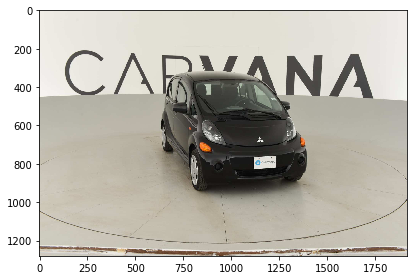

In [3]:
def load_image_and_normalize_and_resize(file_path="",normalize=True):
    if normalize:
        return (imread(file_path)/255)
    else:
        return (imread(file_path))
    

print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]))
print(imshow(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,2)[0])))
print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape)
HEIGH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[0]
WIDTH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[1]

In [4]:
mask = pd.read_csv('../input/carvana-image-masking-challenge/train_masks.csv')

In [5]:
len(mask)

5088

In [6]:
# empezamos a trabajar para obtener la mascara del coche solo nos interesa el coche para mejorar el performanc
# ademas queremos simular los trazos humanos extrayendo los edges del coche (pero solo del coche, el fondo no nos interesa)
import cv2
indx=5000
carimage = car_path+input_files[indx]
maskimage = mask_path+input_files[indx].replace('.jpg','_mask.gif')

print(carimage)
print(maskimage)
img = cv2.imread(carimage)
#mask = cv2.imread(maskimage)
mask=imread(maskimage)
print(mask)



../input/carvana-image-masking-challenge/train/fff9b3a5373f_12.jpg
../input/carvana-image-masking-challenge/train_masks/fff9b3a5373f_12_mask.gif
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


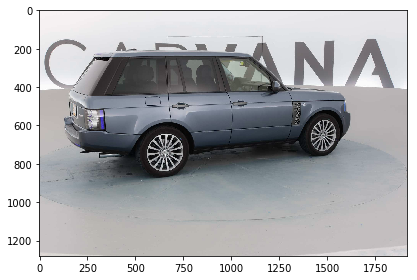

In [7]:
#La imagen original
imshow(img)

(1280, 1918)


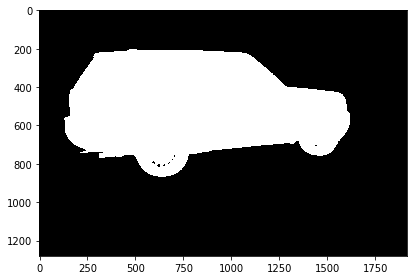

In [8]:
#La mascara
print(mask.shape)
imshow(mask)

In [9]:
from sklearn.model_selection import train_test_split
train_input, test_input, _, _ = train_test_split(input_files, input_files, test_size=0.15, random_state=42)
print(len(train_input))
print(len(test_input))

4324
764


In [10]:
np.random.choice(train_input,1)
train_input[0]

'f7ad86e13ed7_13.jpg'

In [11]:
H = 256
W = 256
BATCH_SIZE=32
def downsample(img, h, w):    
    ret = resize(img, (h, w), mode='constant', preserve_range=True)
    # plt.imshow(ret)
    return ret
    #return cv2.resize(img, (h, w))

def generator_resize(path, batch_size, h, w):
    
    while True:
        input_img=[]
        output_mask=[]
        for x in range(batch_size):
            selected = np.squeeze(np.random.choice(path,1))
            carimage = car_path+str(selected)
            maskimage = mask_path+str(selected).replace('.jpg','_mask.gif')
            img = downsample(imread(carimage), h, w)
            mask=downsample(imread(maskimage), h, w)
            #mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
            input_img.append(img/255)
            output_mask.append(mask.reshape(h,w,1)/255)
            
        yield np.array(input_img), np.array(output_mask)
        
imgs,masks=next(generator_resize(train_input,BATCH_SIZE, H, W))
print(imgs.shape)
print(masks.shape)
print(np.max(imgs))
print(np.max(masks))

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(32, 256, 256, 3)
(32, 256, 256, 1)
1.0
1.0


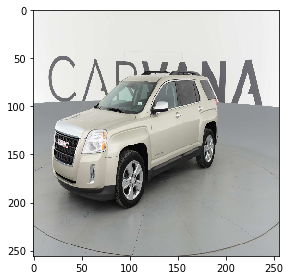

In [12]:
imshow(imgs[2])

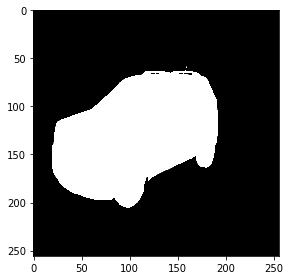

In [13]:
imshow(masks[2].reshape(H,W))

In [14]:
#Vamos a entrenar nuestra Unet classica salidas sigmoid y binarycrossentropy

In [15]:
#Based on my custom old experiments with U-Net
#https://github.com/nopaixx/Py-Models/blob/master/MODEL02-Tensoflow%20Keras%20Unet%20Image%20segmentation.ipynb

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
input_img = Input((H, W, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

In [16]:
#definimos nuestro callback para guardar
saver = ModelCheckpoint('unet-carvana.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [17]:
histo = model.fit_generator(generator_resize(train_input,BATCH_SIZE, H, W),steps_per_epoch=10, epochs=40,
                    validation_data=generator_resize(test_input,BATCH_SIZE, H, W),validation_steps=10,
                    callbacks=[saver])

Instructions for updating:
Use tf.cast instead.
Epoch 1/40


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 115s 12s/step - loss: 0.4565 - acc: 0.8563 - val_loss: 1.4034 - val_acc: 0.8148
Epoch 2/40
10/10 [==============================] - 97s 10s/step - loss: 0.2535 - acc: 0.9682 - val_loss: 0.2915 - val_acc: 0.9588
Epoch 3/40
10/10 [==============================] - 108s 11s/step - loss: 0.1859 - acc: 0.9775 - val_loss: 0.2496 - val_acc: 0.9586
Epoch 4/40
10/10 [==============================] - 108s 11s/step - loss: 0.1511 - acc: 0.9824 - val_loss: 0.1412 - val_acc: 0.9804
Epoch 5/40
10/10 [==============================] - 107s 11s/step - loss: 0.1333 - acc: 0.9845 - val_loss: 0.1159 - val_acc: 0.9852
Epoch 6/40
10/10 [==============================] - 107s 11s/step - loss: 0.1182 - acc: 0.9860 - val_loss: 0.1177 - val_acc: 0.9833
Epoch 7/40
10/10 [==============================] - 107s 11s/step - loss: 0.1092 - acc: 0.9863 - val_loss: 0.1119 - val_acc: 0.9841
Epoch 8/40
10/10 [==============================] - 106s 11s/step - loss: 0.0998 - acc: 

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


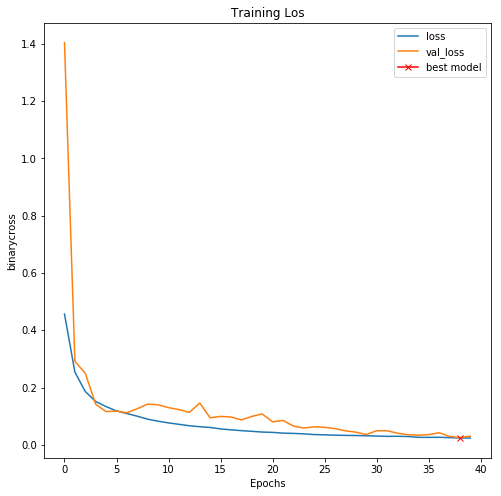

In [18]:

plt.figure(figsize=(8, 8))
plt.title("Training Los")
plt.plot(histo.history["loss"], label="loss")
plt.plot(histo.history["val_loss"], label="val_loss")
plt.plot( np.argmin(histo.history["val_loss"]), np.min(histo.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("binarycross")
plt.legend();

In [19]:
!ls

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


__notebook__.ipynb  __output__.json  unet-carvana.hdf5


In [20]:
inp,out=next(generator_resize(test_input,BATCH_SIZE, H, W))

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [21]:
pred = model.predict(inp)

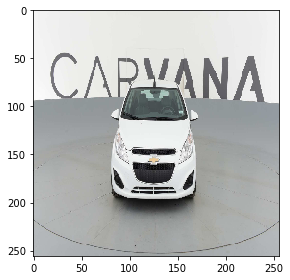

In [22]:
imshow(inp[0])

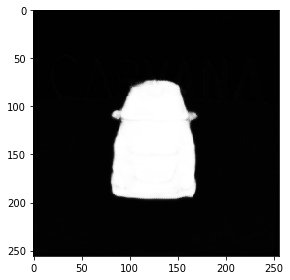

In [23]:
imshow(pred[0].reshape(H,W))

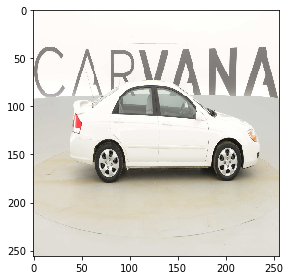

In [24]:
imshow(inp[1])

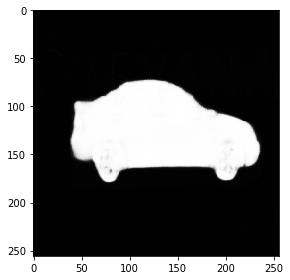

In [25]:
imshow(pred[1].reshape(H,W))

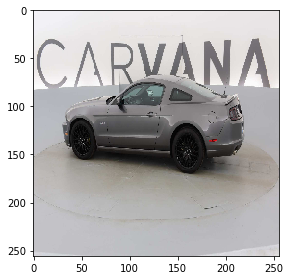

In [26]:
imshow(inp[2])

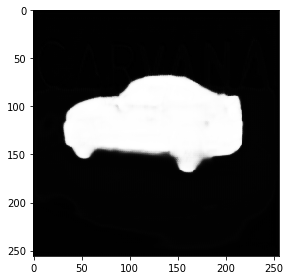

In [27]:
imshow(pred[2].reshape(H,W))